### Empirical Example for RobustiPY (Type 1)!

#### This example is designed to show how basic functionality -- such as OLS can be used with a cross-sectional dataset -- works.

Lets first load in two basic python libraries that we'll need for this example: the `os` module (for path handling), and `matplotlib.pyplot` (for plotting)

In [1]:
import os # for filepath handling
import requests # for grabbing the dataset
import matplotlib.pyplot as plt # for plotting

Note next that this example uses the [union.dta](https://www.stata-press.com/data/r9/nlsw88.dta) dataset. This dataset is a subsample of the file National Longitudinal Survey of Young Women 88 data (Center for Human Resource Research 1989). Women were surveyed in each of the 21 years 1968–1988, except for the six years 1974, 1976, 1979, 1981, 1984, and 1986).

For more information on the NLS (see [http://www.bls.gov/nls/](http://www.bls.gov/nls/) or [https://www.nlsinfo.org/weights/nlsyw](https://www.nlsinfo.org/weights/nlsyw) for more details). Importantly, this dataset is entirely anonymised and publicly available.

Importantly for our purposes, it contains information on things like log-wage, union membership, and so forth.

Importantly, you should make sure that you have a copy of the [union.dta](https://www.stata-press.com/data/r17/union.dta) file located at somewhere like `.data\input`. We are not repackaging this dataset ourselves to be maximally respectful of all appropriate licenses at this time.n.

Now, let's load the two RobustiPy utils that we're going to need:

In [2]:
from robustipy.utils import prepare_union
from robustipy.models import OLSRobust

Our key objective is going to try to assess the effect of unionisation (i.e. our 'x' or '$\beta_1$' on wage. To do this, we'll vary various specifications along the way, and compare our results against other results in the literature\other statistical software.

Next, now that we've got this research question, robustipy installed, and our data set up, lets define a very simple function for this union example, and comment along as we go.

In [3]:
import os
import requests
import statsmodels.formula.api as smf

def union_example():
    """
    A simple function for estimating the wage premium or penalty as a function
    of the NLSW1988 dataset using RobustiPy.

    Inputs:  None
    Outputs: union_results (RobustiPy fit results)
    """
    # 1. Download nlsw88.dta if needed
    def get_nlsw88(url, path, fname):
        response = requests.get(url, stream=True)
        if not os.path.exists(path):
            os.makedirs(path)
            print(f"Directory '{path}' created.")
        else:
            print(f"Directory '{path}' already exists.")
        
        if response.status_code == 200:
            full_path = os.path.join(path, fname)
            with open(full_path, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print(f"Downloaded '{fname}' to '{full_path}'.")
        else:
            raise RuntimeError(f"Failed to download '{url}', status code {response.status_code}.")

    get_nlsw88(
        url='https://www.stata-press.com/data/r10/nlsw88.dta',
        path=os.path.join('..', 'data', 'union_example'),
        fname='nlsw88.dta'
    )

    # 2. Prepare the data (y, z, x, data) via your existing function
    y, z, x, data = prepare_union(
        os.path.join('..', 'data', 'union_example', 'nlsw88.dta')
    )

    # 3. Extract the dependent‐variable name (y_name)
    if isinstance(y, str):
        y_name = y
    else:
        y_name = getattr(y, 'name', None)
        if not isinstance(y_name, str):
            raise ValueError("`y` must be a pandas.Series with a valid `.name` or a string.")

    # 4. Extract the main regressor names (x_names)
    if isinstance(x, str):
        # Split on whitespace and join with ' + '
        x_names = x.strip().split()
    elif hasattr(x, 'columns'):
        x_names = list(x.columns)
    else:
        raise ValueError("`x` must be either a string or a pandas.DataFrame.")

    # 5. Extract the control variable names (z_names)
    if z is None:
        z_names = []
    elif isinstance(z, list) and all(isinstance(var, str) for var in z):
        z_names = z.copy()
    elif hasattr(z, 'columns'):
        z_names = list(z.columns)
    else:
        raise ValueError("`z` must be None, a list of strings, or a pandas.DataFrame.")

    # 6. Verify that each name in x_names + z_names appears in data.columns
    missing = [var for var in (x_names + z_names) if var not in data.columns]
    if missing:
        raise KeyError(f"The following variables are missing from data.columns: {missing}")

    # 7. Build the Patsy‐formula string with spaces around each '+'
    rhs_vars = x_names + z_names
    if not rhs_vars:
        formula_str = f"{y_name} ~ 1"
    else:
        formula_str = f"{y_name} ~ " + " + ".join(rhs_vars)

    # 8. Define helper to run OLS with HC1 robust standard errors
    def run_regression(formula, data, label):
        model = smf.ols(formula=formula, data=data).fit(cov_type='HC1')
        print(f"\n--- Column {label} (HC1) ---")
        print(model.summary())

    # 9. Run the regression using the dynamically constructed formula_str
    run_regression(formula_str, data, label=1)

    # 10. Call RobustiPy’s OLSRobust, passing y, x, and data; use z as controls
    union_robust = OLSRobust(y=[y], x=[x], data=data)
    union_robust.fit(
        controls=z,
        draws=1000,
        kfold=10,
        seed=192735,
        oos_metric='pseudo-r2',
        threshold=2000000
    )

    union_results = union_robust.get_results()
    return union_results


Great: now that we've defined our union plotting function, lets actually call it:

In [4]:
results = union_example()

Directory '../data/union_example' already exists.
Downloaded 'nlsw88.dta' to '../data/union_example/nlsw88.dta'.

--- Column 1 (HC1) ---
                            OLS Regression Results                            
Dep. Variable:               log_wage   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     128.5
Date:                Sat, 07 Jun 2025   Prob (F-statistic):          5.69e-228
Time:                        10:51:09   Log-Likelihood:                -11695.
No. Observations:                2225   AIC:                         2.341e+04
Df Residuals:                    2213   BIC:                         2.348e+04
Df Model:                          11                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0

You haven’t specified the number of CPUs. Is 31 okay? (yes/no):  yes


Output()

OLSRobust is running with n_cpu=31, draws=1000, folds=10, seed=192735.
We're evaluating our out-of-sample predictions with the pseudo-r2 metric.
The estimand of interest is union. Let's begin the calculations...


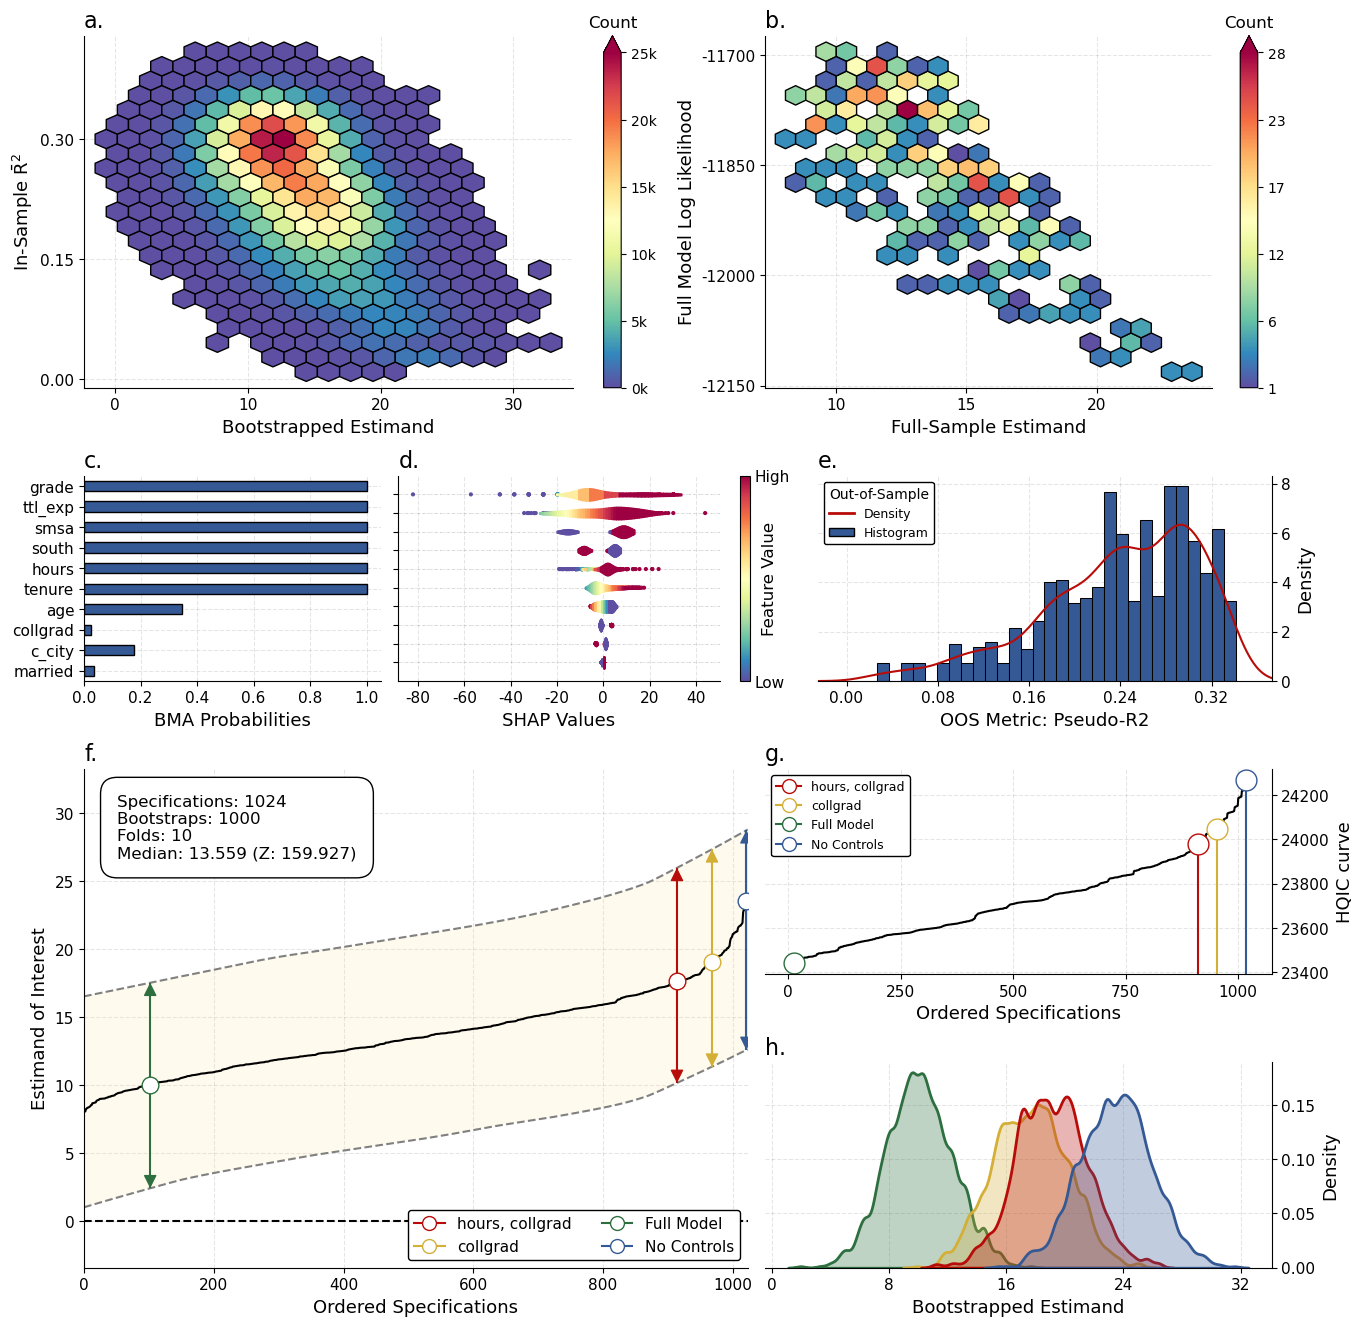

In [8]:
results.plot(specs=[['hours', 'collgrad'],
                    ['collgrad']
                   ],
             ic='hqic',
             ext='svg',
             project_name='union_example',
             figpath = '../figures',
             highlights=True,
             figsize=(16, 16)
            )

In [6]:
results.summary(digits=1)

1. Model Summary
Model: OLS Robust
Inference Tests: Yes
Dependent variable: log_wage
Independent variable: union
Number of possible controls: 10
Number of draws: 1000
Number of folds: 10
Number of specifications: 1024
2.Model Robustness Metrics
2.1 Inference Metrics
Median beta (all specifications, no resampling): 13.5 (p-value: 0.0)
Median beta (all bootstraps and specifications): 13.6
Min beta (all specifications, no resampling): 8.1
Min beta (all bootstraps and specifications): -0.6
Max beta (all specifications, no resampling): 23.7
Max beta (all bootstraps and specifications): 32.8
AIC-weighted beta (all specifications, no resampling): 10.2
BIC-weighted beta (all specifications, no resampling): 9.8
HQIC-weighted beta (all specifications, no resampling): 10.0
Significant portion of beta (all specifications, no resampling): 1.0 (p-value: 0.0)
Significant portion of beta (all bootstraps and specifications): 1.0
Positive portion of beta (all specifications, no resampling): 1.0 (p-value

Ta da!